In [1]:
# Dependencies
import pandas as pd
from scipy.io import loadmat
import glob
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM,Dropout,Dense 
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf


## Step 1: Set up dataset functions
Class has 3 elements
- An ```__init__``` function that sets up your class and all the necessary parameters.
- An ```__len__``` function that returns the size of your dataset.
- An ```__getitem__``` function that given an index within the limits of the size of the dataset returns the associated image and label in tensor form.

In [2]:
# folder names
dc_folders = ['Europe', 'Japan', 'USA']

# Implement the dataset class
class DrivingCyclesDataset(Dataset):
    def __init__(self,
                 path_to_dc,
                 train=True):
        # path_to_dc: where you put the driving cycles dataset
        # idxs_train: training set indexes
        # idxs_test: test set indexes
        # train: return training set or test set
        
        # Load all the driving cycles
        alldata = []
        dcnames = []
        if (train == True):
            mat = loadmat('./DrivingCycles/WLTPextended.mat')
            df = pd.DataFrame(mat['V_z'], columns = ['V_z']) # velocity 
            df2 = pd.DataFrame(mat['T_z'], columns = ['T_z']) # time
            df3 = pd.DataFrame(mat['D_z'], columns = ['D_z']) # acceleration
            df = pd.concat([df, df2, df3], axis=1)
            alldata.append(df)
            dcnames.append('WLTPextended.mat')
            for folder in dc_folders:
                image_path = os.path.join(path_to_dc, folder)
                files = glob.glob(image_path + '/*.mat')
                for f in files:
                    mat = loadmat(f)
                    df = pd.DataFrame(mat['V_z'], columns = ['V_z'])
                    df2 = pd.DataFrame(mat['T_z'], columns = ['T_z'])
                    df3 = pd.DataFrame(mat['D_z'], columns = ['D_z'])
                    df = pd.concat([df, df2, df3], axis=1)
                    dcnames.append(os.path.basename(f))
                    # each dataframe is a driving cycle 
                    alldata.append(df)
            # Extract the driving cycles with the specified file indexes     
            self.data = (np.array(alldata, dtype=object))[p] #numpy array of dataframes 
            self.names = (np.array(dcnames, dtype=object))[p]
        
        else:
            image_path = os.path.join(path_to_dc, 'test')
            files = glob.glob(image_path + '/*.mat')
            for f in files:
                mat = loadmat(f)
                df = pd.DataFrame(mat['V_z'], columns = ['V_z'])
                df2 = pd.DataFrame(mat['T_z'], columns = ['T_z'])
                df3 = pd.DataFrame(mat['D_z'], columns = ['D_z'])
                df = pd.concat([df, df2, df3], axis=1)
                dcnames.append(os.path.basename(f))
                # each dataframe is a driving cycle 
                alldata.append(df)

            self.data = alldata
            self.names = dcnames


    def __len__(self, idx):
        # Return the number of samples in a driving cycle 
        return (self.data[idx]).size
        
    def __getitem__(self, idx):
        # Get an item using its index
        # Return the driving cycle and its name 
        return self.data[idx]

In [3]:
def split_train_test(lendata, percentage=0.8):
    idxs_train = int(percentage * lendata)
    idxs_test = idxs_train + 1 
    return idxs_train, idxs_test

LENDATA = 36 + 6 + 4 + 1 # number of driving cycles = 47
np.random.seed(42)
idxs_train, idxs_test = split_train_test(LENDATA,0.8)
idxs_test = 22 # only 1 test driving cycle for easier visualisation
p = np.random.permutation(int(LENDATA-1))

In [4]:
def create_dataset(dataset, h, f, test):
    x = [] #append the last 50 values
    y = [] #append the future value 
    for df in dataset:
        features_considered = ['V_z', 'D_z']
        # features_considered = ['V_z']
        features = df[features_considered]
        for i in range(h, df.shape[0]-f):
            # for each driving cycle dataframe, have sets of 51 values 
            # h values are past values, f values are future value 
            features['v_ave'] = df['V_z'][i-h:i].mean()
            features['v_max'] = df['V_z'][i-h:i].max()
            features['v_min'] = df['V_z'][i-h:i].min()
            features['a_ave'] = df['D_z'][i-h:i].mean()
            # features['a_max'] = df['D_z'][i-h:i].max()
            # features['a_min'] = df['D_z'][i-h:i].min()
            x.append(features[i-h:i])
            if (test == False):
                y.append(df['V_z'][i:i+f])
            else:
                y.append(df['V_z'][i])
    x = np.array(x) 
    y = np.array(y)  
    # x = np.asarray(x).astype(np.float32)
    return x,y

## Step 2: Exploring the dataset

### Step 2.1: Data visualisation.

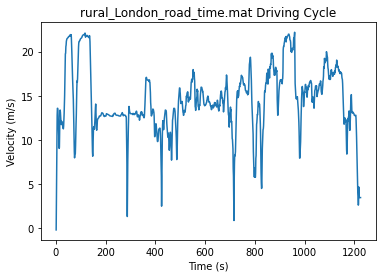

In [5]:
# loading datasets
dc_path = './DrivingCycles/'
dataset_train  = DrivingCyclesDataset(dc_path, train=True)
dataset_test = DrivingCyclesDataset(dc_path, train=False)

# Plot 1 sample from the test set
sample_data = dataset_test.data[0]
sample_name = dataset_test.names[0]
plt.title(sample_name + " Driving Cycle")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.plot(sample_data['T_z'], sample_data['V_z'])
plt.show()

# # Plot samples from the test set
# # Europe NEDC 
# sample_data = dataset_train.data[26]
# sample_name = dataset_train.names[26]
# print(sample_data.describe())
# plt.title(sample_name + " Driving Cycle")
# plt.xlabel("Time (s)")
# plt.ylabel("Velocity (m/s)")
# plt.plot(sample_data['T_z'], sample_data['V_z'])
# plt.show()

# # Europe WLTP 
# sample_data = dataset_train.data[37]
# sample_name = dataset_train.names[37]
# print(sample_data.describe())
# plt.title(sample_name + " Driving Cycle")
# plt.xlabel("Time (s)")
# plt.ylabel("Velocity (m/s)")
# plt.plot(sample_data['T_z'], sample_data['V_z'])
# plt.show()

# # Japan 10 Mode 
# sample_data = dataset_train.data[30]
# sample_name = dataset_train.names[30]
# print(sample_data.describe())
# plt.title(sample_name + " Driving Cycle")
# plt.xlabel("Time (s)")
# plt.ylabel("Velocity (m/s)")
# plt.plot(sample_data['T_z'], sample_data['V_z'])
# plt.show()

# # US FTP_75 
# sample_data = dataset_train.data[17]
# sample_name = dataset_train.names[17]
# print(sample_data.describe())
# plt.title(sample_name + " Driving Cycle")
# plt.xlabel("Time (s)")
# plt.ylabel("Velocity (m/s)")
# plt.plot(sample_data['T_z'], sample_data['V_z'])
# plt.show()


### Step 2.2 Load dataset

In [6]:
# scaling the datasets 
scaler = MinMaxScaler(feature_range=(0,1))
for df in dataset_train: 
    df['V_z'] = scaler.fit_transform(df[['V_z']])
    df['D_z'] = scaler.fit_transform(df[['D_z']])
for df in dataset_test: 
    df['V_z'] = scaler.fit_transform(df[['V_z']])
    df['D_z'] = scaler.fit_transform(df[['D_z']])

# parameters h and f
h = 15 # length of historical sequence
f = 10 # length of forecast sequence 

# create training set and test set 
pd.options.mode.chained_assignment = None
x_train, y_train = create_dataset(dataset_train, h, f, test=False)
x_test, y_test = create_dataset(dataset_test, h, f, test=True)

# check 
print(x_train.shape)
print(x_test.shape)

# reshaping input to LSTM model 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

(133453, 15, 6)
(1200, 15, 6)


## Step 3: LSTM
In this section we will try to make a LSTM predictor to predict the future velocity. 

### Step 3.1: Define the model. 


#### Step 3.1.1: Hyperparameter Search (Keras Tuner)

In [179]:
# importing libraries
import keras
from keras_tuner import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import EarlyStopping

# defining model space search
def build_model(hp):
    model = Sequential()
    # tuning number of neurons
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=256,step=32),return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
    # tuning number of layers
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=256,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=256,step=32)))
    # dropout layer
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    # dense layer and activation function
    model.add(Dense(y_train.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

# create Tuner object
tuner= BayesianOptimization(
        build_model,
        objective='mse',
        max_trials=5,
        executions_per_trial=1
        )

# hyperparameter search 
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
tuner.search(x_train, y_train,epochs=2, steps_per_epoch = 100,
     validation_split=0.2,verbose=1, callbacks=[early_stopping])

# best model
best_model = tuner.get_best_models(num_models=1)[0]
print(best_model.summary())

# best hyperparameter
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print('HyperParameters: {}'.format(best_hyperparameters))

# prediction 
predictions=best_model.predict(x_test)

# saving model 
best_model.save('bestLSTM.h5')

Trial 5 Complete [00h 10m 54s]
mse: 0.0014821626245975494

Best mse So Far: 0.0014821626245975494
Total elapsed time: 00h 48m 21s
INFO:tensorflow:Oracle triggered exit


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4992      
                                                                 
 lstm_1 (LSTM)               (None, 15, 256)           295936    
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 827,525
Trainable params: 827,525
Non-trainable params: 0
_________________________________________________________________
None
HyperParameters: {'input_unit': 32, 'n_layers

#### old model

In [8]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) # units depends on create_dataset function
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=f, activation='softmax'))


#### Step 3.1.2: Load model 

In [10]:
model = load_model('bestLSTM.h5') 

# check
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(type(x_train))
print(type(y_test))

print(y_test)

print(model.summary())

OSError: No file or directory found at bestLSTM.h5

### Step 3.2: Compile model

- Loss function
- Optimizer
- Learning Rate
- Number of iterations
- Batch Size
- Other relevant hyperparameters

In [11]:
# compile the model 
model.compile(loss='mse', optimizer='adam')

### Step 3.3: Train the model.

In [12]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
model.fit(x_train, y_train, epochs=10, batch_size=50, validation_split=0.2, callbacks=[early_stopping])
# model.fit(x_train, y_train, epochs=10, batch_size=50)
model.save('speed_prediction.h5')

# load the model 
model = load_model('speed_prediction.h5') 

Epoch 1/10
2136/2136 [==============================] - 306s 131ms/step - loss: 0.1870 - val_loss: 0.1666
Epoch 2/10
2136/2136 [==============================] - 295s 138ms/step - loss: 0.1869 - val_loss: 0.1666
Epoch 3/10
2136/2136 [==============================] - 267s 125ms/step - loss: 0.1869 - val_loss: 0.1666
Epoch 4/10
2136/2136 [==============================] - 267s 125ms/step - loss: 0.1869 - val_loss: 0.1666
Epoch 5/10
2136/2136 [==============================] - 210s 98ms/step - loss: 0.1869 - val_loss: 0.1666
Epoch 6/10
2136/2136 [==============================] - 177s 83ms/step - loss: 0.1869 - val_loss: 0.1666
Epoch 7/10
2136/2136 [==============================] - 175s 82ms/step - loss: 0.1869 - val_loss: 0.1666


### Step 3.4: Deploy the trained model onto the test set. 

In [13]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# check
print(predictions.shape)

(1200, 10)


In [14]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

#check
print(y_test_scaled.shape)

(1200, 1)


### Step 3.5: Evaluate model performance

In [15]:
results = model.evaluate(x_test, y_test, batch_size=50)
print("MSE loss: ", results)


24/24 [==============================] - 7s 60ms/step - loss: 0.3429
MSE loss:  0.3429349660873413


### Step 3.6: Visualisation of prediction

Text(0, 0.5, 'Time (s)')

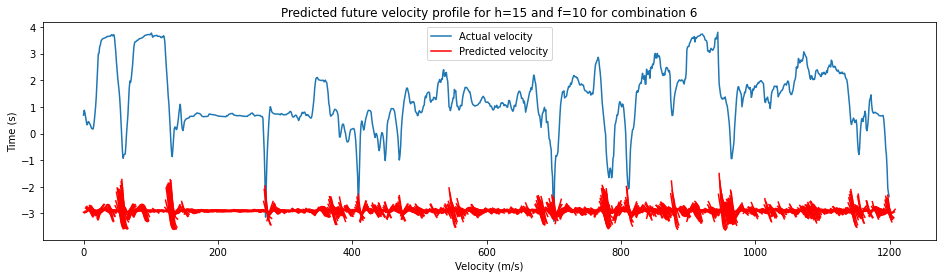

In [16]:
# Combination information
combi = '6'

# plotting
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(y_test_scaled)
# plt.plot(predictions, color='red') 
for i in range(predictions.shape[0]): 
    plt.plot(range(i,i+f), predictions[i], color='red') 
plt.legend(['Actual velocity', 'Predicted velocity'])
title = 'Predicted future velocity profile for h=' + str(h) + ' and f=' + str(f) + ' for combination ' + str(combi)
plt.title(title)
plt.xlabel("Velocity (m/s)")
plt.ylabel("Time (s)")

## Step 4: Baseline model


In [83]:
# Baseline model 
# assumption that the forecast is equal to the mean of the historical time sequence 
def create_baseline_results(dataset, h, f):
    y = []  
    y_true = []
    for df in dataset:
        for i in range(h, df.shape[0]-f):
            # for each driving cycle dataframe, have sets of 51 values 
            # h values are past values, f values are future value 
            # features = df['V_z']
            features = df['V_z'][i-h:i].mean()
            features = [features]*f
            y.append(features)
            y_true.append(df['V_z'][i:i+f])
        print(i)
    y = np.array(y)  
    y_true = np.array(y_true) 
    return y, y_true

dc_path = './DrivingCycles/'
dataset_test = DrivingCyclesDataset(dc_path, train=False)

# scaling the datasets 
scaler = MinMaxScaler(feature_range=(0,1))
for df in dataset_train: 
    df['V_z'] = scaler.fit_transform(df[['V_z']])
    df['D_z'] = scaler.fit_transform(df[['D_z']])
for df in dataset_test: 
    df['V_z'] = scaler.fit_transform(df[['V_z']])
    df['D_z'] = scaler.fit_transform(df[['D_z']])

# parameters h and f
h = 50 # length of historical sequence
f = 20 # length of forecast sequence 

# create training set and test set 
pd.options.mode.chained_assignment = None
predictions, y_hat = create_baseline_results(dataset_test, h, f)

# evaluating the model
print(predictions.shape)
print(y_hat.shape)
mse_ = tf.keras.losses.MeanSquaredError()
mse = mse_(predictions,y_hat)
print('mse:', mse)

1204
(1155, 20)
(1155, 20)
mse: tf.Tensor(0.02477300353348255, shape=(), dtype=float64)
